In [27]:
# import ee
# 
# # Trigger the authentication flow.
# # ee.Authenticate()
# 
# ee.Initialize(project='ee-arzaaan789')

In [28]:
# import pandas as pd
# 
# df = pd.read_csv("uk_grid_1000m.csv")
# # rename longitude to 'decimalLongitude' and latitude to 'decimalLatitude'
# df.rename(columns={'longitude': 'decimalLongitude', 'latitude': 'decimalLatitude'}, inplace=True)
# # set eventDate to 1st May 2025
# df['eventDate'] = pd.to_datetime('2025-06-01')
# df.head()

,decimalLongitude,decimalLatitude,eventDate
0,-6.347425,49.893656,2025-06-01
1,-6.333543,49.894177,2025-06-01
2,-6.321265,49.912633,2025-06-01
3,-6.307377,49.913150,2025-06-01
4,-6.293488,49.913666,2025-06-01


In [29]:
# import ee
# import pandas as pd
# from datetime import datetime, timedelta
# from tqdm import tqdm
# 
# # ee.Initialize()
# 
# # Your dataframe 'df' must have columns: decimalLongitude, decimalLatitude
# # Example: df = pd.read_csv("Erinaceus europaeus.csv", delimiter='\t')
# 
# def create_aoi(lon, lat, box_size_km=1):
#     """Create approx 1km x 1km square polygon around lon, lat."""
#     half_side_deg = box_size_km / 111.32 / 2  # Rough approx degrees per km
# 
#     coords = [
#         [lon - half_side_deg, lat - half_side_deg],
#         [lon + half_side_deg, lat - half_side_deg],
#         [lon + half_side_deg, lat + half_side_deg],
#         [lon - half_side_deg, lat + half_side_deg],
#         [lon - half_side_deg, lat - half_side_deg]
#     ]
#     return ee.Geometry.Polygon(coords)
# 
# def compute_all_indices(feature, start_date, end_date):
#     """Compute spectral indices and LST for one EE Feature (with AOI geometry)."""
#     aoi = feature.geometry()
# 
#     s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
#           .filterBounds(aoi)
#           .filterDate(start_date, end_date)
#           .sort('CLOUDY_PIXEL_PERCENTAGE')
#           .first())
#     s2 = ee.Image(s2).clip(aoi)
# 
#     blue = s2.select('B2')
#     green = s2.select('B3')
#     red = s2.select('B4')
#     nir = s2.select('B8')
#     swir = s2.select('B11')
# 
#     L = 0.5  # SAVI constant
# 
#     ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
#     ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
#     ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')
#     savi = nir.subtract(red).divide(nir.add(red).add(L)).multiply(1 + L).rename('SAVI')
#     mndwi = green.subtract(swir).divide(green.add(swir)).rename('MNDWI')
#     ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')
#     bsi = (red.add(blue).subtract(nir.add(swir))).divide(red.add(blue).add(nir).add(swir)).rename('BSI')
#     ui = nir.subtract(swir).divide(nir.add(swir)).rename('UI')
# 
#     reducers = ee.Reducer.mean()
#     scale_10m = 1000
# 
#     ndvi_mean = ndvi.reduceRegion(reducers, aoi, scale_10m).get('NDVI')
#     ndwi_mean = ndwi.reduceRegion(reducers, aoi, scale_10m).get('NDWI')
#     ndbi_mean = ndbi.reduceRegion(reducers, aoi, scale_10m).get('NDBI')
#     savi_mean = savi.reduceRegion(reducers, aoi, scale_10m).get('SAVI')
#     mndwi_mean = mndwi.reduceRegion(reducers, aoi, scale_10m).get('MNDWI')
#     ndsi_mean = ndsi.reduceRegion(reducers, aoi, scale_10m).get('NDSI')
#     bsi_mean = bsi.reduceRegion(reducers, aoi, scale_10m).get('BSI')
#     ui_mean = ui.reduceRegion(reducers, aoi, scale_10m).get('UI')
# 
#     # MODIS LST dataset
#     modis = (ee.ImageCollection("MODIS/061/MOD11A1")
#              .filterBounds(aoi)
#              .filterDate(start_date, end_date)
#              .select('LST_Day_1km'))
# 
#     lst_mean_img = modis.mean().multiply(0.02).clip(aoi)
# 
#     lst_mean = lst_mean_img.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=aoi,
#         scale=1000
#     ).get('LST_Day_1km')
# 
#     return feature.set({
#         'NDVI': ndvi_mean,
#         'NDWI': ndwi_mean,
#         'NDBI': ndbi_mean,
#         'SAVI': savi_mean,
#         'MNDWI': mndwi_mean,
#         'NDSI': ndsi_mean,
#         'BSI': bsi_mean,
#         'UI': ui_mean,
#         'LST': lst_mean
#     })
# 
# # Split df into batches
# batch_size = 50
# batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]
# 
# results_list = []
# 
# index_names = ['NDVI', 'NDWI', 'NDBI', 'SAVI', 'MNDWI', 'NDSI', 'BSI', 'UI', 'LST']
# 
# for batch in tqdm(batches, desc="Processing batches"):
#     features = []
#     batch_indices = []
#     feature_metadata = {}
# 
#     for idx, row in batch.iterrows():
#         
#         aoi = create_aoi(row['decimalLongitude'], row['decimalLatitude'])
#         feature = ee.Feature(aoi).set('index', idx)
#         features.append(feature)
#         batch_indices.append(idx)  # Save the original index
#         
#         event_date = row['eventDate']
#         start_date = (event_date - timedelta(days=15)).strftime('%Y-%m-%d')
#         end_date = (event_date + timedelta(days=15)).strftime('%Y-%m-%d')
#         feature_metadata[idx] = (start_date, end_date)
# 
#     # Create a FeatureCollection from the list of features
#     fc = ee.FeatureCollection(features)
#     
#     # Define wrapper for map to inject per-feature dates
#     def map_with_dates(f):
#         idx = f.get('index')
#         # Use dictionary lookup to get dates for this feature
#         date_dict = ee.Dictionary(ee.Dictionary(feature_metadata))
#         dates = ee.List(date_dict.get(ee.Number(idx)))
#         return compute_all_indices(f, dates.get(0), dates.get(1))
# 
#     try:
#         result_fc = fc.map(map_with_dates)
#         results = result_fc.getInfo()
# 
#         rows = []
#         for f in results['features']:
#             props = f['properties']
#             rows.append(props)
# 
#     except Exception as e:
#         print(f"Error processing batch starting at index {batch.index[0]}: {e}")
#         # If there's an error, create placeholder rows with None
#         rows = [{'index': i, **{name: None for name in index_names}} for i in batch_indices]
# 
#     batch_results_df = pd.DataFrame(rows).sort_values('index').reset_index(drop=True)
#     results_list.append(batch_results_df)
# 
# # Concatenate all batches and sort by original index
# all_results_df = pd.concat(results_list).sort_values('index').reset_index(drop=True)
# 
# # Merge with original df
# df_final = pd.concat([df.reset_index(drop=True), all_results_df.drop(columns=['index'])], axis=1)
# 
# print(df_final.head())


Processing batches: 100%|██████████| 4888/4888 [13:49:26<00:00, 10.18s/it]   


   decimalLongitude  decimalLatitude  eventDate       BSI         LST  \
0         -6.347425        49.893656 2025-06-01 -0.486515  289.980000   
1         -6.333543        49.894177 2025-06-01 -0.533775         NaN   
2         -6.321265        49.912633 2025-06-01 -0.444581  280.300000   
3         -6.307377        49.913150 2025-06-01 -0.621371  289.999250   
4         -6.293488        49.913666 2025-06-01 -0.719280  290.706667   

      MNDWI      NDBI      NDSI      NDVI      NDWI      SAVI        UI  
0 -0.283105 -0.237348 -0.283105  0.553412 -0.483623  0.829881  0.237348  
1 -0.313951 -0.229969 -0.313951  0.601115 -0.508422  0.901449  0.229969  
2 -0.233918 -0.242840 -0.233918  0.516397 -0.431643  0.774486  0.242840  
3 -0.391363 -0.281401 -0.391363  0.663213 -0.594777  0.994679  0.281401  
4 -0.463755 -0.323644 -0.463755  0.756636 -0.684624  1.134827  0.323644  


In [1]:
# df_final.to_csv("bat_inference_data_indices.csv", index=False)
import pandas as pd
df = pd.read_csv("inference_data_indices.csv")
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')

In [2]:
ceratopogonidae = pd.read_csv("Ceratopogonidae.csv", delimiter='\t')
ceratopogonidae = ceratopogonidae[ceratopogonidae["occurrenceStatus"] == "PRESENT"]
ceratopogonidae = ceratopogonidae[ceratopogonidae['year']>=2022]
ceratopogonidae['eventDate'] = pd.to_datetime(ceratopogonidae['eventDate'], format='%Y-%m-%d', errors='coerce')
ceratopogonidae = ceratopogonidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
ceratopogonidae = ceratopogonidae.dropna().reset_index(drop=True)

chironomidae = pd.read_csv("Chironomidae.csv", delimiter='\t')
chironomidae = chironomidae[chironomidae["occurrenceStatus"] == "PRESENT"]
chironomidae = chironomidae[chironomidae['year']>=2022]
chironomidae['eventDate'] = pd.to_datetime(chironomidae['eventDate'], format='%Y-%m-%d', errors='coerce')
chironomidae = chironomidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
chironomidae = chironomidae.dropna().reset_index(drop=True)

cats = pd.read_csv("cats.csv", delimiter='\t')
cats = cats[cats["occurrenceStatus"] == "PRESENT"]
cats = cats[cats['year']>=2022]
cats['eventDate'] = pd.to_datetime(cats['eventDate'], format='%Y-%m-%d', errors='coerce')
cats = cats[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
cats = cats.dropna().reset_index(drop=True)


wind_turbines = pd.read_excel("REPD_202407_WIND.xlsx")
wind_turbines = wind_turbines[wind_turbines['DEVSTATSHT']=='Operational']
wind_turbines = wind_turbines[['LAT','LNG']]
wind_turbines = wind_turbines.rename(columns={'LAT': 'decimalLatitude', 'LNG': 'decimalLongitude'})
wind_turbines = wind_turbines.dropna().reset_index(drop=True)

In [3]:
import numpy as np
from sklearn.neighbors import BallTree
from tqdm import tqdm

# Convert lat/lon to radians for BallTree
bat_coords = np.deg2rad(df[['decimalLatitude', 'decimalLongitude']].values)
ceratopogonidae_coords = np.deg2rad(ceratopogonidae[['decimalLatitude', 'decimalLongitude']].values)
chironomidae_coords = np.deg2rad(chironomidae[['decimalLatitude', 'decimalLongitude']].values)
cats_coords = np.deg2rad(cats[['decimalLatitude', 'decimalLongitude']].values)
wind_turbines_coords = np.deg2rad(wind_turbines[['decimalLatitude', 'decimalLongitude']].values)

# Build BallTree using haversine metric
tree_ceratopogonidae = BallTree(ceratopogonidae_coords, metric='haversine')
tree_chironomidae = BallTree(chironomidae_coords, metric='haversine')
tree_cats = BallTree(cats_coords, metric='haversine')
tree_wind_turbines = BallTree(wind_turbines_coords, metric='haversine')

# Define search radius: 1 km in radians
earth_radius_km = 6371.0
radius = 1 / earth_radius_km  # 1 km in radians

# Initialize presence columns
df['ceratopogonidae_presence'] = 0
df['chironomidae_presence'] = 0
df['cats_presence'] = 0

# Iterate through each bat point with tqdm for progress tracking
for i in tqdm(range(len(df))):
    point = bat_coords[i].reshape(1, -1)
    event_month = df.loc[i, 'eventDate'].month
    event_year = df.loc[i, 'eventDate'].year

    # CERATOPOGONIDAE
    idxs = tree_ceratopogonidae.query_radius(point, r=radius)[0]
    for j in idxs:
        ceratopogonidae_date = ceratopogonidae.loc[j, 'eventDate']
        if ceratopogonidae_date.month == event_month and ceratopogonidae_date.year == event_year:
            df.at[i, 'ceratopogonidae_presence'] = 1
            break  # Found at least one match, no need to check further

    # CHIRONOMIDAE
    idxs = tree_chironomidae.query_radius(point, r=radius)[0]
    for j in idxs:
        chironomidae_date = chironomidae.loc[j, 'eventDate']
        if chironomidae_date.month == event_month and chironomidae_date.year == event_year:
            df.at[i, 'chironomidae_presence'] = 1
            break  # Found at least one match, no need to check further
            
    # CATS
    idxs = tree_cats.query_radius(point, r=radius)[0]
    for j in idxs:
        cats_date = cats.loc[j, 'eventDate']
        if cats_date.month == event_month and cats_date.year == event_year:
            df.at[i, 'cats_presence'] = 1
            break  # Found at least one match, no need to check further
        
indices = tree_wind_turbines.query_radius(bat_coords, r=radius)
df['wind_turbines_presence'] = [1 if len(neighbors) > 0 else 0 for neighbors in indices]

100%|██████████| 244359/244359 [00:19<00:00, 12648.60it/s]


In [6]:
import osmnx as ox
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from tqdm import tqdm


# Construct GeoDataFrame
df['geometry'] = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Define spatial tiling: 0.05 x 0.05 degrees
tile_size_lat = 0.009   # ~1 km in latitude degrees
tile_size_lon = 0.0157  # ~1 km in longitude degrees
padding_lat = 0.002  # ~200m latitude padding
padding_lon = 0.003  # ~200-300m longitude padding

gdf['tile_x'] = (gdf['decimalLongitude'] // tile_size_lon).astype(int)
gdf['tile_y'] = (gdf['decimalLatitude'] // tile_size_lat).astype(int)

# Group by tile
grouped = gdf.groupby(['tile_x', 'tile_y'])

# Store results
all_distances = []

for (tile_x, tile_y), group in tqdm(grouped, total=len(grouped)):
    west = tile_x * tile_size_lon - padding_lon
    south = tile_y * tile_size_lat - padding_lat
    east = (tile_x + 1) * tile_size_lon + padding_lon
    north = (tile_y + 1) * tile_size_lat + padding_lat
    bbox = (west, south, east, north)


    try:
        G = ox.graph_from_bbox(bbox, network_type='drive_service')
        if len(G.nodes) == 0:
            all_distances.extend([np.nan] * len(group))
            continue

        G_proj = ox.project_graph(G)
        nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)
        points_proj = group.geometry.to_crs(nodes_proj.crs)

        for point_proj in points_proj:
            try:
                u, v, k = ox.distance.nearest_edges(G_proj, [point_proj.x], [point_proj.y])[0]
                edge_geom = edges_proj.loc[(u, v, k)]['geometry']
                distance = point_proj.distance(edge_geom)
                all_distances.append(distance)
            except Exception as e:
                all_distances.append(np.nan)

    except Exception as e:
        all_distances.extend([np.nan] * len(group))


# Store back in original DataFrame order
gdf['distance_to_road'] = all_distances

100%|██████████| 234672/234672 [83:23:05<00:00,  1.28s/it]       


In [7]:
# gdf.to_csv("temp.csv", index=False)

In [44]:
gdf = gpd.read_file("temp.csv")
gdf['distance_to_road'] = pd.to_numeric(gdf['distance_to_road'])

In [45]:
gdf['near_road'] = np.where(gdf['distance_to_road'] <= 500, 1, 0)        
gdf

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,...,UI,ceratopogonidae_presence,chironomidae_presence,cats_presence,wind_turbines_presence,geometry,tile_x,tile_y,distance_to_road,near_road
0,-6.347425272382747,49.89365614995138,2025-06-01,-0.4865147897098812,289.98,-0.2831050510196254,-0.2373477017781713,-0.2831050510196254,0.5534122925392636,-0.4836228264964965,...,0.2373477017781713,0,0,0,0,POINT (-6.347425272382747 49.89365614995138),-405,5543,NaN,0
1,-6.333542862518806,49.89417680762447,2025-06-01,-0.5337749731690665,,-0.3139508010199416,-0.2299686634146684,-0.3139508010199416,0.6011151989403121,-0.5084222501504781,...,0.2299686634146684,0,0,0,0,POINT (-6.333542862518806 49.89417680762447),-404,5543,NaN,0
2,-6.321265107494903,49.9126325088973,2025-06-01,-0.4445805102755829,280.3,-0.2339180543147412,-0.2428401862841314,-0.2339180543147412,0.5163973624123362,-0.4316429424627486,...,0.2428401862841314,0,0,0,0,POINT (-6.321265107494903 49.9126325088973),-403,5545,NaN,0
3,-6.307376770926201,49.91315017696439,2025-06-01,-0.6213706638225358,289.9992495636999,-0.391363433503516,-0.2814008291875154,-0.391363433503516,0.6632132991028967,-0.5947767504482001,...,0.2814008291875154,0,0,0,0,POINT (-6.307376770926201 49.91315017696439),-402,5545,NaN,0
4,-6.293488032036451,49.91366618566916,2025-06-01,-0.7192801993077155,290.7066666666667,-0.4637549271905581,-0.3236435904075205,-0.4637549271905581,0.7566364399440424,-0.6846240112265888,...,0.3236435904075205,0,0,0,0,POINT (-6.293488032036451 49.91366618566916),-401,5545,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244354,-0.7903829351937774,60.824445123136385,2025-06-01,-0.3111648622740678,285.7177398169144,-0.1559583932988236,-0.0984330303611343,-0.1559583932988236,0.4128770249261168,-0.2340571108773797,...,0.0984330303611343,0,0,0,0,POINT (-0.7903829351937774 60.824445123136385),-51,6758,25.587944,1
244355,-0.8819879053659186,60.83421708709028,2025-06-01,-0.6661721573028754,284.5406666666667,-0.5292576293483138,-0.1826105528276242,-0.5292576293483138,0.6604503525699079,-0.6492153495865226,...,0.1826105528276242,0,0,0,0,POINT (-0.8819879053659186 60.83421708709028),-57,6759,45.208361,1
244356,-0.8452097039272767,60.8339061961782,2025-06-01,-0.4184440115460433,283.57454545454544,-0.3325822576999087,-0.0504142055228407,-0.3325822576999087,0.4173401494480326,-0.3573813773526169,...,0.0504142055228407,0,0,0,0,POINT (-0.8452097039272767 60.8339061961782),-54,6759,0.611822,1
244357,-0.7716558439598786,60.83325423064069,2025-06-01,0.2325164666117846,,0.3362273603064131,-0.1304484727732197,0.3362273603064131,-0.0517353186397485,0.2151975426561123,...,0.1304484727732197,0,0,0,0,POINT (-0.7716558439598786 60.83325423064069),-50,6759,20.637597,1


In [46]:
gdf=gdf.drop(['tile_x', 'tile_y', 'geometry', 'distance_to_road'], axis=1)


In [47]:
gdf['decimalLatitude'] = gdf['decimalLatitude'].astype(float)
gdf['decimalLongitude'] = gdf['decimalLongitude'].astype(float)

In [48]:
from pyproj import Transformer
from rasterio.windows import Window
import rasterio
from collections import Counter
import numpy as np


land_cover_map = {
    1: "Deciduous woodland",
    2: "Coniferous woodland",
    3: "Arable",
    4: "Improved grassland",
    5: "Neutral grassland",
    6: "Calcareous grassland",
    7: "Acid grassland",
    8: "Fen",
    9: "Heather",
    10: "Heather grassland",
    11: "Bog",
    12: "Inland rock",
    13: "Saltwater",
    14: "Freshwater",
    15: "Supralittoral rock",
    16: "Supralittoral sediment",
    17: "Littoral rock",
    18: "Littoral sediment",
    19: "Saltmarsh",
    20: "Urban",
    21: "Suburban"
}

# Batch coordinate transformation
transformer_ni = Transformer.from_crs("EPSG:4326", "EPSG:29903", always_xy=True)
transformer_gb = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

coords = list(zip(gdf['decimalLongitude'], gdf['decimalLatitude']))
gdf['easting_ni'], gdf['northing_ni'] = zip(*transformer_ni.itransform(coords))
gdf['easting_gb'], gdf['northing_gb'] = zip(*transformer_gb.itransform(coords))

# Raster processing optimization
gb_raster = 'gblcm2023_10m.tif'
n_ireland_raster = 'nilcm2023_10m.tif'


def get_land_cover_class_1km(row):
    try:
        window_size_pixels = 100  # 1 km / 10m resolution

        # Open GB raster and read 1km x 1km window
        with rasterio.open(gb_raster) as src:
            row_idx, col_idx = src.index(row['easting_gb'], row['northing_gb'])

            # Calculate window bounds, making sure not to go out of raster bounds
            row_start = max(row_idx - window_size_pixels // 2, 0)
            col_start = max(col_idx - window_size_pixels // 2, 0)

            # Adjust window size if near edges
            height = min(window_size_pixels, src.height - row_start)
            width = min(window_size_pixels, src.width - col_start)

            window = Window(col_start, row_start, width, height)
            data = src.read(1, window=window)

            # If all zero (or no data), fallback to NI raster
            if np.all(data == 0):
                with rasterio.open(n_ireland_raster) as src_ni:
                    row_idx_ni, col_idx_ni = src_ni.index(row['easting_ni'], row['northing_ni'])

                    row_start_ni = max(row_idx_ni - window_size_pixels // 2, 0)
                    col_start_ni = max(col_idx_ni - window_size_pixels // 2, 0)

                    height_ni = min(window_size_pixels, src_ni.height - row_start_ni)
                    width_ni = min(window_size_pixels, src_ni.width - col_start_ni)

                    window_ni = Window(col_start_ni, row_start_ni, width_ni, height_ni)
                    data_ni = src_ni.read(1, window=window_ni)

                    data = data_ni

            # Find the most common class (mode) ignoring zeros (assuming 0 means no data)
            unique, counts = np.unique(data[data != 0], return_counts=True)
            if len(counts) == 0:
                return "Unknown"

            mode_class = unique[np.argmax(counts)]
            return land_cover_map.get(mode_class, "Unknown")

    except Exception as e:
        print(f"Error processing row: {e}")
        return "Unknown"


tqdm.pandas()
gdf['Land_cover'] = gdf.progress_apply(get_land_cover_class_1km, axis=1)


 19%|█▉        | 46111/244359 [32:46<2:54:23, 18.95it/s] 

Error processing row: Number of columns or rows must be non-negative


100%|██████████| 244359/244359 [3:02:35<00:00, 22.30it/s]  


In [49]:
gdf = gdf.dropna()
gdf=gdf.drop(['easting_ni', 'northing_ni', 'easting_gb', 'northing_gb'],axis=1)
# Remove where Land_cover is Unknown
gdf = gdf[gdf['Land_cover'] != "Unknown"].reset_index(drop=True)

In [50]:
gdf.head(10)

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,SAVI,UI,ceratopogonidae_presence,chironomidae_presence,cats_presence,wind_turbines_presence,near_road,Land_cover
0,-6.347425,49.893656,2025-06-01,-0.4865147897098812,289.98,-0.2831050510196254,-0.2373477017781713,-0.2831050510196254,0.5534122925392636,-0.4836228264964965,0.8298805988867348,0.2373477017781713,0,0,0,0,0,Improved grassland
1,-6.333543,49.894177,2025-06-01,-0.5337749731690665,,-0.3139508010199416,-0.2299686634146684,-0.3139508010199416,0.6011151989403121,-0.5084222501504781,0.9014489234778812,0.2299686634146684,0,0,0,0,0,Supralittoral rock
2,-6.321265,49.912633,2025-06-01,-0.4445805102755829,280.3,-0.2339180543147412,-0.2428401862841314,-0.2339180543147412,0.5163973624123362,-0.4316429424627486,0.7744856487356677,0.2428401862841314,0,0,0,0,0,Improved grassland
3,-6.307377,49.913150,2025-06-01,-0.6213706638225358,289.9992495636999,-0.391363433503516,-0.2814008291875154,-0.391363433503516,0.6632132991028967,-0.5947767504482001,0.9946793781456684,0.2814008291875154,0,0,0,0,0,Improved grassland
4,-6.293488,49.913666,2025-06-01,-0.7192801993077155,290.7066666666667,-0.4637549271905581,-0.3236435904075205,-0.4637549271905581,0.7566364399440424,-0.6846240112265888,1.134827076079225,0.3236435904075205,0,0,0,0,0,Improved grassland
5,-6.308177,49.922119,2025-06-01,-0.6222078038838577,289.91869908306916,-0.3314609671081401,-0.3551747375705033,-0.3314609671081401,0.6861706718900626,-0.5761600649175316,1.0291452896950013,0.3551747375705033,0,0,0,0,1,Improved grassland
6,-6.294286,49.922635,2025-06-01,-0.735673395565456,289.8617416572929,-0.4728382558977743,-0.320711693372489,-0.4728382558977743,0.7620236504234961,-0.6890022169033537,1.1429146305478672,0.320711693372489,0,0,0,0,0,Improved grassland
7,-6.280394,49.923149,2025-06-01,-0.2035050995887116,290.205625,-0.0392160641123373,-0.1737426279455187,-0.0392160641123373,0.3263383625567452,-0.1948672225170743,0.4892817760928012,0.1737426279455187,0,0,0,0,0,Improved grassland
8,-6.350657,49.929528,2025-06-01,-0.0632289859113111,,0.2596242537730715,-0.2917761751645943,0.2596242537730715,0.2811648663901283,-0.0372733209504422,0.4214870503029419,0.2917761751645943,0,0,0,0,0,Supralittoral rock
9,-6.308978,49.931087,2025-06-01,-0.4437917028759833,289.14767706803,-0.187860564690404,-0.2984269186478698,-0.187860564690404,0.5446389994007438,-0.3954263730312858,0.8168706494584492,0.2984269186478698,0,0,0,0,1,Improved grassland


In [51]:
gdf = gdf.dropna()
gdf = gdf.drop_duplicates()
bat_bool_columns = ['ceratopogonidae_presence','chironomidae_presence','cats_presence','wind_turbines_presence','near_road']
gdf[bat_bool_columns] = gdf[bat_bool_columns].astype(bool)
gdf = pd.get_dummies(gdf, columns=['Land_cover'])
gdf.to_csv("bat_inference_data_preprocessed.csv")

In [53]:
gdf = pd.read_csv("bat_inference_data_preprocessed.csv")
gdf = gdf.astype({col: 'int' for col in gdf.select_dtypes(include='bool').columns})

#read scaler
import joblib
scaler = joblib.load("bat_scaler.pkl")
# Scale the data
env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
gdf[env_vars] = scaler.transform(gdf[env_vars])
# drop Unnamed: 0
gdf

,Unnamed: 0,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,...,Land_cover_Inland rock,Land_cover_Littoral rock,Land_cover_Littoral sediment,Land_cover_Neutral grassland,Land_cover_Saltmarsh,Land_cover_Saltwater,Land_cover_Suburban,Land_cover_Supralittoral rock,Land_cover_Supralittoral sediment,Land_cover_Urban
0,0,-6.347425,49.893656,2025-06-01,0.388086,-0.851205,0.640883,-0.180025,0.640883,-0.186201,...,0,0,0,0,0,0,0,0,0,0
1,1,-6.333543,49.894177,2025-06-01,0.168473,NaN,0.476007,-0.116573,0.476007,0.050486,...,0,0,0,0,0,0,0,1,0,0
2,2,-6.321265,49.912633,2025-06-01,0.582950,-2.435584,0.903795,-0.227256,0.903795,-0.369857,...,0,0,0,0,0,0,0,0,0,0
3,3,-6.307377,49.913150,2025-06-01,-0.238576,-0.848054,0.062224,-0.558841,0.062224,0.358597,...,0,0,0,0,0,0,0,0,0,0
4,4,-6.293488,49.913666,2025-06-01,-0.693551,-0.732268,-0.324720,-0.922090,-0.324720,0.822133,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244351,244351,-0.790383,60.824445,2025-06-01,1.202919,-1.548832,1.320502,1.014511,1.320502,-0.883492,...,0,0,0,0,0,0,0,0,0,0
244352,244352,-0.881988,60.834217,2025-06-01,-0.446764,-1.741491,-0.674842,0.290663,-0.674842,0.344888,...,0,0,0,0,0,0,0,0,0,0
244353,244353,-0.845210,60.833906,2025-06-01,0.704404,-1.899621,0.376419,1.427428,0.376419,-0.861348,...,0,0,0,0,0,0,0,0,0,0
244354,244354,-0.771656,60.833254,2025-06-01,3.729351,NaN,3.951314,0.739208,3.951314,-3.188752,...,0,0,0,0,0,0,0,1,0,0


In [57]:
gdf.to_csv("bat_inference_data_preprocessed_final.csv")

In [6]:
import pandas as pd
df = pd.read_csv("bat_inference_data_preprocessed_final.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1',
                      'Land_cover_Calcareous grassland', 'Land_cover_Littoral rock', 'Land_cover_Supralittoral rock'
                      ])
df = df.dropna()

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class DeepMaxEntModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# Custom deepmaxent_loss
# ============================
def deepmaxent_loss(logits, targets):
    probs = torch.sigmoid(logits)
    eps = 1e-8
    loss = - (targets * torch.log(probs + eps) +
              (1 - targets) * torch.log(1 - probs + eps))
    return loss.mean()

In [9]:
import numpy as np

models_list = ["bat_BCEWithLogitsLoss_roc_best_model.pth"]
input_dim = df.shape[1] - 3  # Exclude 'decimalLatitude', 'decimalLongitude', 'eventDate'

X_inference = df.drop(columns=['decimalLatitude', 'decimalLongitude', 'eventDate']).values
X_inference_tensor = torch.tensor(X_inference, dtype=torch.float32)

all_probs = []
for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_inference_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
# Average probabilities
ensemble_probs = np.mean(all_probs, axis=0)

# add probabilities to df
df['probability'] = ensemble_probs # Assuming the second column is the positive class
df.to_csv("bat_results.csv", index=False)
df

,decimalLongitude,decimalLatitude,eventDate,BSI,LST,MNDWI,NDBI,NDSI,NDVI,NDWI,...,Land_cover_Improved grassland,Land_cover_Inland rock,Land_cover_Littoral sediment,Land_cover_Neutral grassland,Land_cover_Saltmarsh,Land_cover_Saltwater,Land_cover_Suburban,Land_cover_Supralittoral sediment,Land_cover_Urban,probability
0,-6.347425,49.893656,2025-06-01,0.388086,-0.851205,0.640883,-0.180025,0.640883,-0.186201,0.407807,...,1,0,0,0,0,0,0,0,0,0.551442
2,-6.321265,49.912633,2025-06-01,0.582950,-2.435584,0.903795,-0.227256,0.903795,-0.369857,0.692762,...,1,0,0,0,0,0,0,0,0,0.580599
3,-6.307377,49.913150,2025-06-01,-0.238576,-0.848054,0.062224,-0.558841,0.062224,0.358597,-0.201542,...,1,0,0,0,0,0,0,0,0,0.552273
4,-6.293488,49.913666,2025-06-01,-0.693551,-0.732268,-0.324720,-0.922090,-0.324720,0.822133,-0.694087,...,1,0,0,0,0,0,0,0,0,0.561826
5,-6.308177,49.922119,2025-06-01,-0.242466,-0.861239,0.382413,-1.193228,0.382413,0.472504,-0.099485,...,1,0,0,0,0,0,0,0,0,0.534989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244350,-0.808766,60.824609,2025-06-01,-0.607123,-1.854684,-0.990796,0.523936,-0.990796,0.410749,-0.676480,...,0,0,0,0,0,0,0,0,0,0.530499
244351,-0.790383,60.824445,2025-06-01,1.202919,-1.548832,1.320502,1.014511,1.320502,-0.883492,1.775933,...,1,0,0,0,0,0,0,0,0,0.593523
244352,-0.881988,60.834217,2025-06-01,-0.446764,-1.741491,-0.674842,0.290663,-0.674842,0.344888,-0.499976,...,0,0,0,0,0,0,0,0,0,0.531625
244353,-0.845210,60.833906,2025-06-01,0.704404,-1.899621,0.376419,1.427428,0.376419,-0.861348,1.099866,...,0,0,0,0,0,0,0,0,0,0.604699


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_12186/678170025.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uk_union = uk_countries.unary_union


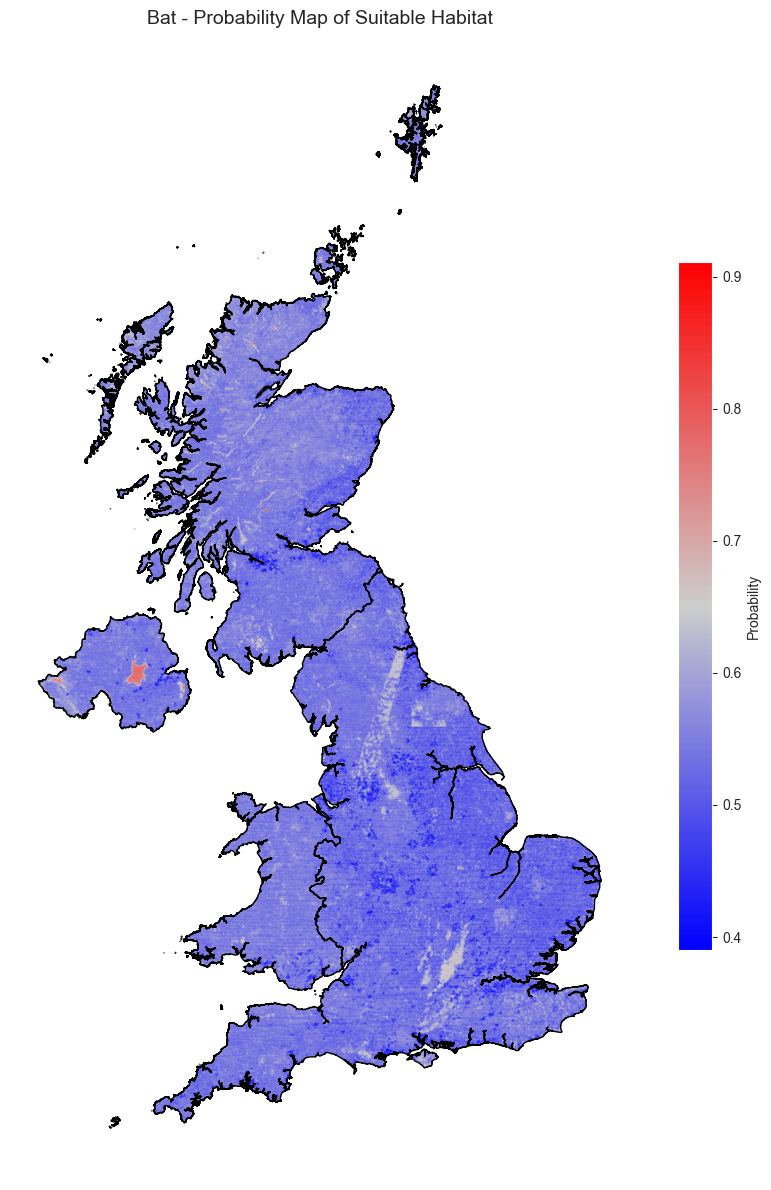

In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from shapely.geometry import Point
from shapely.prepared import prep

# Load UK shapefile and prepare land geometry
uk_countries = gpd.read_file('data/CTRY_DEC_2024_UK_BFC.shp')
uk_countries = uk_countries[
    uk_countries['CTRY24NM'].isin(['England', 'Scotland', 'Wales', 'Northern Ireland'])
].to_crs('EPSG:27700')
uk_union = uk_countries.unary_union
uk_polygon = prep(uk_union)  # prepared geometry for fast masking

# Load and project point data
data = pd.read_csv("bat_results.csv")
points_gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs='EPSG:4326'
).to_crs('EPSG:27700')

# Interpolation setup
x = points_gdf.geometry.x.values
y = points_gdf.geometry.y.values
z = points_gdf['probability'].values

# Create fine grid (500m resolution)
grid_res = 500
xi = np.arange(x.min(), x.max(), grid_res)
yi = np.arange(y.min(), y.max(), grid_res)
xi, yi = np.meshgrid(xi, yi)

# Interpolate with linear method
zi = griddata((x, y), z, (xi, yi), method='linear')

# Mask grid: keep only points inside the UK polygon
grid_points = [Point(x, y) for x, y in zip(xi.flatten(), yi.flatten())]
mask = np.array([uk_polygon.contains(pt) for pt in grid_points])
zi_masked = np.ma.masked_where(~mask.reshape(xi.shape), zi)

# Define colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom",
    ["blue",
     # "#7072EE", 
     # "#00CDFF", 
     "#CDCDCD", 
     # "#FF00FE", 
     # "#FC79f6", 
     "red"]
)
norm = mcolors.Normalize(vmin=np.nanmin(zi_masked), vmax=np.nanmax(zi_masked))

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
img = ax.imshow(
    zi_masked,
    origin='lower',
    extent=(xi.min(), xi.max(), yi.min(), yi.max()),
    cmap=cmap,
    norm=norm
)

# Overlay UK boundaries
uk_countries.boundary.plot(ax=ax, color='black', linewidth=1)

# Colorbar
cbar = plt.colorbar(img, ax=ax, shrink=0.6, label='Probability')
ax.set_title('Bat - Probability Map of Suitable Habitat', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [13]:
#save the image
fig.savefig("bat_probability_map.png", dpi=300, bbox_inches='tight')